# Hamiltonian of the system of pairs of spins with ancillas

The time evolution of a system initially in the state $\vert\psi(0)\rangle$ takes the form:
$$
\vert \psi(t) \rangle = e^{-i H t} \vert \psi(0) \rangle \text{,}
$$

The Hamitonian for our system is 
$$
 H=v\sum_{i=0}^{K-1} Z_{2i} Z_{2i+1} + w \sum_{i=0}^{K-2} Z_{2i+1} Z_{2i+2}
$$

Let's K denotes number of 2-spins cells, and L the number of spin qubits, L=2K

In [1]:
from qiskit.quantum_info import SparsePauliOp
from math import sin, cos

def get_hamiltonian(K, v,w):

    # List of Hamiltonian terms as 3-tuples containing
    # (1) the Pauli string,
    # (2) the qubit indices corresponding to the Pauli string,
    # (3) the coefficient.
    ZZ = [("ZZ", [2*i, 2*i + 1], v) for i in range(0, K )]
    ZZ+= [("ZZ", [2*i+1, 2*i + 2], w) for i in range(0, K - 1)]
    L=2*K

    # We create the Hamiltonian as a SparsePauliOp, via the method
    # `from_sparse_list`, and multiply by the interaction term.
    hamiltonian = SparsePauliOp.from_sparse_list([*ZZ], num_qubits=L)
    return hamiltonian.simplify(),L

In [2]:
H,L = get_hamiltonian(K=4, v=0.2,w=-0.3 )
H,L

(SparsePauliOp(['IIIIIIZZ', 'IIIIZZII', 'IIZZIIII', 'ZZIIIIII', 'IIIIIZZI', 'IIIZZIII', 'IZZIIIII'],
               coeffs=[ 0.2+0.j,  0.2+0.j,  0.2+0.j,  0.2+0.j, -0.3+0.j, -0.3+0.j, -0.3+0.j]),
 8)

Let us define a *magnetization operator* $\sum_i Z_i$, and a *mean spin correlation operator* $\sum_i Z_i Z_{i+1} / (L - 1)$.

In [3]:
magnetization_op = SparsePauliOp.from_sparse_list(
    [("Z", [i], 1.0) for i in range(0, L)], num_qubits=L
)
correlation_op = SparsePauliOp.from_sparse_list(
    [("ZZ", [i, i + 1], 1.0) for i in range(0, L - 1)], num_qubits=L
) / (L - 1)

In [4]:
from qiskit_algorithms import TrotterQRTE
from qiskit.primitives import Estimator
#from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit.quantum_info import Statevector
from qiskit_algorithms import TimeEvolutionProblem

num_timesteps = 60
trotter = TrotterQRTE(num_timesteps=num_timesteps, estimator=Estimator())

/tmp/ipykernel_18/3588108927.py:8: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  trotter = TrotterQRTE(num_timesteps=num_timesteps, estimator=Estimator())


In [5]:
final_time = 30.0
initial_state = Statevector.from_label("00110011")
assert len(initial_state.dims())==L  # tmp
problem = TimeEvolutionProblem(
    H,
    initial_state=initial_state,
    time=final_time,
    aux_operators=[H, magnetization_op, correlation_op],
)

 let our TrotterQRTE evolve our newly created problem instance.

In [6]:
result = trotter.evolve(problem)

The new result also features an observables attribute. Let's extract the observables stored in it.

In [7]:
import numpy as np

observables = np.array(np.array(result.observables)[:, :, 0])
observables.shape

(61, 3)

Text(0.5, 0.98, 'Observable evolution')

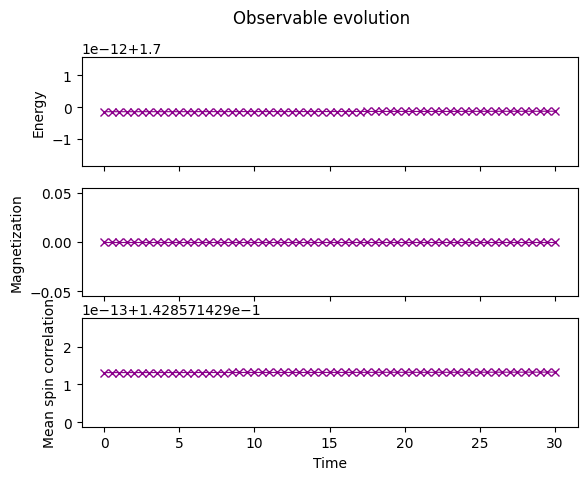

In [8]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, sharex=True)
times = np.linspace(0, final_time, num_timesteps + 1)  # includes initial state
axes[0].plot(
    times, observables[:, 0], label="First order", marker="x", c="darkmagenta", ls="-", lw=0.8
)
axes[1].plot(
    times, observables[:, 1], label="First order", marker="x", c="darkmagenta", ls="-", lw=0.8
)
axes[2].plot(
    times, observables[:, 2], label="First order", marker="x", c="darkmagenta", ls="-", lw=0.8
)
axes[0].set_ylabel("Energy")
axes[1].set_ylabel("Magnetization")
axes[2].set_ylabel("Mean spin correlation")
axes[2].set_xlabel("Time")
fig.suptitle("Observable evolution")